- By: Proskurin Oleksandr
- Email: proskurinolexandr@gmail.com
- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 59-73

# Introduction

In Chapter 3 notebooks, we have understood how Triple-Barrier and Meta-Labelling concepts work. The next problem in financial machine learning is non-independent samples as a result of that standard machine learning models like Random Forest and Bagging Classifier need to be modified. In this notebook we will tackle the proble of concurrency and the solution to that - __Sequential Bootstrapping__. 

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import mlfinlab as ml
from numba import jit, prange
from mlfinlab.sampling.bootstrapping import get_ind_mat_average_uniqueness, get_ind_matrix, seq_bootstrap
from mlfinlab.sampling.concurrent import get_av_uniqueness_from_tripple_barrier

We take dollar bars and barrier events generated from https://github.com/hudson-and-thames/research/blob/master/Chapter3/2019-03-06_JJ_Trend-Follow-Question.ipynb

In [3]:
barrier_events = pd.read_csv('barrier_events.csv', index_col=0, parse_dates=[0,2]) 
close_prices = pd.read_csv('official_data/dollar_bars.csv', index_col=0, parse_dates=[0,2])

In financial machine learning, samples are not independent. The most part of traditional machine learning algorithms assume that samples are i.i.d, in case of financial machine learning samples are neither identically distributed not indepedent.
In this section we will tackle the problem of samples dependency. As you remember, we mostly label our datasets using triple-barrier method. Each label in triple-barrier event has label index and label endtime (t1) which corresponds to time when one of barriers was touched. Let's look at example of 3 samples: A, B, C. 

Imagine that 

A was generated at $t_1$ and triggered on $t_8$

B was generated at $t_3$ and triggered on $t_6$

C was generated on $t_7$ and triggered on $t_9$

In this case we see that A used information about returns on $[t_1,t_8]$ to generate label-endtime which overlaps with $[t_3, t_6]$ which was used by B, however C didn't use any returns information which was used by to label other samples. Here we would like to introduce the concept of concurrency. 

We say that labels $y_i$ and $y_j$ are concurrent at $t$ if they are a function of at least one common return at $r_{t-1,t}$

In terms of concurrency label C is the most 'pure' as it doesn't use any piece of information from other labels, while A is the 'dirtiest' as it uses information from both B and C. We can measure average label uniqueness using get_av_uniqueness_from_tripple_barrier function from mlfinlab package

In [4]:
av_unique = get_av_uniqueness_from_tripple_barrier(barrier_events, close_prices.close, num_threads=3)

2019-07-11 14:05:35.694291 100.0% num_concurrent_events done after 0.03 minutes. Remaining 0.0 minutes..
2019-07-11 14:05:37.332421 100.0% _get_average_uniqueness done after 0.02 minutes. Remaining 0.0 minutes..


By understanding average label uniqueness you can measure how 'pure' your dataset is based on concurrency of labels

In [5]:
av_unique.mean()

tW    0.163135
dtype: float64

Let's look at one of the labels which have average uniqueness equal to 1 which means that it doesn't use any information from other labels

In [6]:
unique_label_index = av_unique[av_unique.tW == 1].index[0] # take the first sample 

In [7]:
unique_label_index

Timestamp('2012-02-27 15:08:12.160000')

In [8]:
barrier_events[barrier_events.index >= unique_label_index].head()

,side,t1,trgt
2012-02-27 15:08:12.160,-1.0,2012-02-28 06:13:08.151,0.005140
2012-03-07 14:52:28.079,-1.0,2012-03-08 09:14:10.272,0.005617
2012-03-07 16:10:42.766,1.0,2012-03-08 09:14:10.272,0.006731
2012-03-07 20:48:01.998,1.0,2012-03-08 19:53:12.251,0.008542
2012-03-08 08:00:15.623,1.0,2012-03-08 20:15:41.320,0.008443


As you can see sample 2012-02-27 15:08:12.160 doesn't use any information from 2012-03-07 14:52:28.079 which is the next label.

We would like to build our model in such a way that it takes into account labels concurrency. In order to do that we need to look at bootstrapping algorithm of Random Forest.


# Bagging, Bootstrapping and Random Forest

The key power of ensemble learning techniques is bagging (which is bootstrapping with replacement). The key idea behind bagging is to randomly choose samples for each decision tree. In this case trees become diverse and by averaging predictions of diverse tress built on randomly selected samples and random subset of features data scientists make the algorithm much less prone to overfit. 

However, in our case we would not only like to randomly choose samples but also choose samples which are unique and non-concurrent. But how can we solve this problem? Here comes Sequential Bootstrapping algorithm.

The key idea behind Sequential Bootstrapping is to select samples in such a way that on each iteration we maximize average uniqueness of selected subsamples. Let's try to understand how this technique works on toy example from the book.

Consider a set of labels $\left\{y_i\right\}_{i=0,1,2}$ where: 

label $y_0$ is a function of return $r_{0,2}$

label $y_1$ is a function of return $r_{2,3}$

label $y_2$ is a function of return $r_{4,5}$

The first thing we need to do is to build and indicator matrix. Columns of this matrix correspond to samples and rows correspond to price returns timestamps which were used during samples labelling. In our case indicator matrix is

In [9]:
ind_mat = pd.DataFrame(index = range(0,6), columns=range(0,3))

In [10]:
ind_mat.loc[:, 0] = [1, 1, 1, 0, 0, 0]
ind_mat.loc[:, 1] = [0, 0, 1, 1, 0, 0]
ind_mat.loc[:, 2] = [0, 0, 0, 0, 1, 1]

In [11]:
ind_mat

,0,1,2
0,1,0,0
1,1,0,0
2,1,1,0
3,0,1,0
4,0,0,1
5,0,0,1


One can use get_ind_matrix method from mlfinlab to build indicator matrix from triple-barrier events.

In [12]:
triple_barrier_ind_mat = get_ind_matrix(barrier_events)

We can get average label uniqueness on indicator matrix using get_ind_mat_average_uniqueness function from mlfinlab.

In [13]:
ind_mat_uniqueness = get_ind_mat_average_uniqueness(triple_barrier_ind_mat)

Let's get the first sample average uniqueness (we need to filter out zeros to get unbiased result).

In [14]:
first_sample = ind_mat_uniqueness[0]
first_sample[first_sample > 0].mean()

0.26886446886446885

In [15]:
av_unique.iloc[0]

tW    0.238776
Name: 2011-09-05 14:12:23.480000, dtype: float64

As you can see it is quite close to values generated by __get_av_uniqueness_from_tripple_barrier__ function call. 

Let's move back to our example. In Sequential Bootstrapping algorithm we start with an empty array of samples ($phi$) and loop through all samples to get the probability of chosing the sample based on average uniqueness of reduced indicator matrix constructed from [previously chosen columns] + sample

`
phi = []
while length(phi) < number of samples to bootstrap:
    average_uniqueness_array = []
    for sample in samples:
        previous_columns  = phi
        ind_mat_reduced = ind_mat[previous_columns + i]
        average_uniqueness_array[sample] = get_ind_mat_average_uniqueness(ind_mat_reduced)   
    // normalise so that probabilities sum up to 1
    probability_array = average_uniqueness_array / sum(average_uniqueness_array) 
    chosen_sample = random_choice(samples, probability = probability_array)
    phi.append(chosen_sample)`

For peformance increase we optimized and parallesied for-loop using numba, which corresponds to bootstrap_loop_run function.

Not let's finish the example

In [16]:
ind_mat

,0,1,2
0,1,0,0
1,1,0,0
2,1,1,0
3,0,1,0
4,0,0,1
5,0,0,1


to be as close to mlfinlab implementation let's convert ind_mat to numpy matrix

In [17]:
ind_mat = ind_mat.values

1st iteration

On the first step all labels will have equal probalities as average uniqueness of matrix with 1 column is 1. Say we have chosen 1 on the first step

2nd iteration

In [18]:
phi = [1] # Sample chosen from the 2st step
uniqueness_array = np.array([None, None, None])
for i in range(0, 3):
    ind_mat_reduced = ind_mat[:, phi + [i]]
    label_uniqueness = get_ind_mat_average_uniqueness(ind_mat_reduced)[-1] # The last value corresponds to appended i
    uniqueness_array[i] = (label_uniqueness[label_uniqueness > 0].mean())
prob_array = uniqueness_array / sum(uniqueness_array)


/home/alex/anaconda3/lib/python3.7/site-packages/mlfinlab/sampling/bootstrapping.py:50: RuntimeWarning: invalid value encountered in true_divide
  average = ind_mat.T / conc
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [19]:
prob_array

array([0.35714285714285715, 0.21428571428571427, 0.42857142857142855],
      dtype=object)

Probably the second chosen feature will be 2 (prob_array[2] = 0.42857 which is the largest probability). As you can see up till now the algorithm has chosen two the least concurrent labels (1 and 2)

3rd iteration

In [20]:
phi = [1,2]
uniqueness_array = np.array([None, None, None])
for i in range(0, 3):
    ind_mat_reduced = ind_mat[:, phi + [i]]
    label_uniqueness = get_ind_mat_average_uniqueness(ind_mat_reduced)[-1]
    uniqueness_array[i] = (label_uniqueness[label_uniqueness > 0].mean())
prob_array = uniqueness_array / sum(uniqueness_array)

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [21]:
prob_array

array([0.45454545454545453, 0.2727272727272727, 0.2727272727272727],
      dtype=object)

Sequential Bootstrapping tries to minimise the probability of repeated samples so as you can see the most probable sample would be 0 with 1 and 2 already selected.

4th iteration

In [22]:
phi = [1, 2, 0]
uniqueness_array = np.array([None, None, None])
for i in range(0, 3):
    ind_mat_reduced = ind_mat[:, phi + [i]]
    label_uniqueness = get_ind_mat_average_uniqueness(ind_mat_reduced)[-1]
    uniqueness_array[i] = (label_uniqueness[label_uniqueness > 0].mean())
prob_array = uniqueness_array / sum(uniqueness_array)

In [23]:
prob_array

array([0.32653061224489793, 0.3061224489795918, 0.36734693877551017],
      dtype=object)

The most probable sample would be 2 in this case

After 4 steps of sequential bootstrapping our drawn samples are [1,2,0,2]

Let's see how this example is solved by mlfinlab implementation. To reproduce that:

1) we need to set warmup to [1], which corresponds to phi = [1] on the first step

2) verbose = True to print updated probabilities

In [37]:
samples = seq_bootstrap(ind_mat, sample_length=4, warmup_samples=[1], verbose=True)

[0.33333333 0.33333333 0.33333333]
[0.35714286 0.21428571 0.42857143]
[0.45454545 0.27272727 0.27272727]
[0.32653061 0.30612245 0.36734694]


In [38]:
samples

[1, 2, 0, 2]

As you can see the first 2 iterations of algorithm yield the same probabilities, however sometimes the algorithm randomly chooses not the 2 sample on 2nd iteration that is why further probabilities are different from the example above. However, if you repeat the process several times you'll see that on average drawn sample equal to the one from the example 

# Monte-Carlo experiment

Let's see how sequential bootstrapping increases average label uniqueness on this example by generating 3 samples using sequential bootstrapping and 3 samples using standard random choise, repeat the experiment 10000 times and record corresponding label uniqueness in each experiment

In [39]:
standard_unq_array = np.zeros(10000) * np.nan # Array of random sampling uniqueness
seq_unq_array = np.zeros(10000) * np.nan # Array of Sequential Bootstapping uniqueness
for i in range(0, 10000):
    bootstrapped_samples = seq_bootstrap(ind_mat, sample_length=3)
    random_samples = np.random.choice(ind_mat.shape[1], size=3)
    
    random_unq = get_ind_mat_average_uniqueness(ind_mat[:, random_samples])
    random_unq_mean = random_unq[random_unq > 0].mean()

    sequential_unq = get_ind_mat_average_uniqueness(ind_mat[:, bootstrapped_samples])
    sequential_unq_mean = sequential_unq[sequential_unq > 0].mean()
    
    standard_unq_array[i] = random_unq_mean
    seq_unq_array[i] = sequential_unq_mean

/home/alex/anaconda3/lib/python3.7/site-packages/mlfinlab/sampling/bootstrapping.py:50: RuntimeWarning: invalid value encountered in true_divide
  average = ind_mat.T / conc
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [40]:
np.median(standard_unq_array), np.median(seq_unq_array)

(0.6666666666666666, 0.6666666666666666)

In [41]:
np.mean(standard_unq_array), np.mean(seq_unq_array)

(0.6430261904761904, 0.7036232142857142)

KDE plots of label uniqueness support the fact taht sequential bootstrapping gives higher average label uniqueness

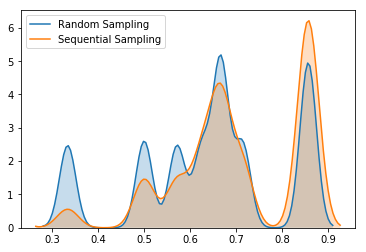

In [42]:
sns.kdeplot(standard_unq_array, shade=True, label='Random Sampling')
sns.kdeplot(seq_unq_array, shade=True, label='Sequential Sampling')

We can compare average label uniqueness using sequential bootstrap vs label uniqueness using standard random sampling by setting compare parameter to True. We have massively increased the performance of Sequential Bootstrapping which was described in the book. For comparison generating 50 samples from 8000 barrier-events would take 3 days, we have reduced time to 10-12 seconds which decreases by increasing number of CPUs.

Let's apply sequential bootstrapping to our full data set and draw 50 samples.

In [44]:
bootstrapped_samples = seq_bootstrap(triple_barrier_ind_mat, compare=True, sample_length=50)

Standard uniqueness: 0.9465875370919882
Sequential uniqueness: 0.9913169319826338


Sometimes you would see that standard bootstrapping gives higher uniqueness, however as it was shown in Monte-Carlo example, on average Sequential Bootstrapping algorithm has higher average uniqueness.

# Conclusion

We have understood the concept of concurrency and how it can make your data set 'impure', how Sequential Bootstrapping can help us to tackle concurrency proble. The next step is to combine standard Random Forest with Sequential Bootstrapping and show how SequentiallyBootstrappedRandomForest increase quality of our machine learning models.